# Mapping school data

In this notebook, we will merged the clean School-Level Master File (SCHMA) data, expenditure report data, and school demographic and accountability data, then begin exploring spatial patterns in the data by mapping.

First, we load the data:

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_2010 = pd.read_csv('../../data/merged_data/expenditure_demo_account_year_2010.csv', index_col=0)
data_2011 = pd.read_csv('../../data/merged_data/expenditure_demo_account_year_2011.csv', index_col=0)
data_2012 = pd.read_csv('../../data/merged_data/expenditure_demo_account_year_2012.csv', index_col=0)

all_years_data = {2010: data_2010, 2011: data_2011, 2012: data_2012}

SCHMA = pd.read_csv('../../data/clean_SCHMA.csv', index_col=0).reset_index(drop=True)

In [3]:
SCHMA.head(6)

,YEAR,LCGGEOX,LCGGEOY,BNLONG
0,2010,-73.9793,40.72200,M015
1,2010,-73.9838,40.72964,M019
2,2010,-73.9866,40.72137,M020
3,2010,-73.9753,40.72647,M034
4,2010,-73.9863,40.72417,M063
5,2010,-73.9816,40.72441,M064


Before we merge the data, we add normalized expenditure features (normalizing by total per student expenditures) for each school.

In [4]:
for year in all_years_data:
    ##Drop non-expenditure and non-numeric fields, then normalize
    numeric = all_years_data[year].drop(['School','District','Title_1', 'Name', 'schoolyear',
                                         'fl_percent', 'frl_percent', 'total_enrollment', 'ell_percent',
                                         'sped_percent', 'asian_per', 'black_per', 'hispanic_per', 'white_per',
                                         'male_per', 'female_per', 'poverty_level', 'elementary_school',
                                         'middle_school', 'high_school'], axis=1)
    numeric = numeric.div(numeric.Total, axis='index')
    
    ##Concatenate back together
    all_years_data[year] = all_years_data[year].join(numeric, how='inner',  rsuffix='_percent_of_total')
    
    #Finally merge in SCHMA lat/long coordinates
    all_years_data[year] = pd.merge(all_years_data[year], SCHMA[SCHMA['YEAR'] == year], how='inner', left_index=True, right_on='BNLONG')
    all_years_data[year].set_index(all_years_data[year].BNLONG, inplace=True)
    all_years_data[year].drop(['YEAR','BNLONG'], axis=1, inplace=True)

all_years_data[year].head(4)

,Additions_to_Salary__Projected_Expenses,After_School_and_Student_Activities,Ancillary_Support_Services_All_Funds,Assistant_Principals,Attendance__Outreach_Services,Building_Maintenance,Building_Services_All_Funds,Central_Administration_All_Funds,Central_Instructional_Support_All_Funds,Classroom_Instruction_All_Funds,...,Summer_and_Evening_School_percent_of_total,Supervisors_percent_of_total,Supplies_Materials_Equipment_Telephones_percent_of_total,SystemWide_Costs_percent_of_total,Teachers_percent_of_total,Text_Books_percent_of_total,Total_percent_of_total,Transportation_percent_of_total,LCGGEOX,LCGGEOY
BNLONG,,,,,,,,,,,,,,,,,,,,,
K001,103,53,1177,460,28,289,1263,384,85,9708,...,0.001321,0.000402,0.006661,0.026987,0.450965,0.003158,1,0.007637,-74.0124,40.64919
K002,107,292,1707,817,306,615,1785,386,83,10477,...,0.003271,0.000327,0.005281,0.021917,0.404739,0.002523,1,0.022524,-73.9515,40.65624
K003,92,75,1603,330,33,581,1662,384,81,9820,...,0.006862,0.000223,0.006694,0.025940,0.458887,0.003012,1,0.028116,-73.9554,40.68258
K005,118,146,2620,430,185,204,751,387,88,10807,...,0.001993,0.000317,0.004302,0.021511,0.396296,0.002536,1,0.056200,-73.9226,40.68561


Again, let's check for missing values:

In [5]:
for year in all_years_data:
    print '\nYear = ', str(year)
    print 'Number observations', len(all_years_data[year])
    print 'Missing variable counts:', all_years_data[year].drop(['fl_percent', 'frl_percent'],axis=1).isnull().sum().sum()


Year =  2010
Number observations 1472
Missing variable counts: 0

Year =  2011
Number observations 1499
Missing variable counts: 0

Year =  2012
Number observations 1510
Missing variable counts: 0


Now we're ready to begin plotting maps. Let's first make a single map, then making a mapping function that can be wrapped in a ipywidget.

Before we proceed, note we want to use a color map (cmap) to show the variation in schools for the specified expenditure category. To maximize the visual difference between schools, we'll transform the specified feature to a percentile score, such that the feature is (approximately) uniformly distributed between 0 and 1.

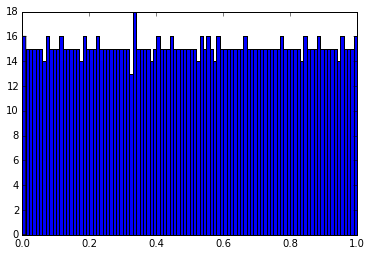

In [7]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

data = all_years_data[2012]
percentiles = [stats.percentileofscore(data['Total'],x,kind='weak')/100.0 for x in data['Total']]
percentile_hist = plt.hist(percentiles, bins=100)

Now let's begin mapping.

In [8]:
from mpl_toolkits.basemap import Basemap

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-8271038.16594,4931552.16054,-8202020.08165,5004969.47023&bboxSR=3857&imageSR=3857&size=1500,1595&dpi=96&format=png32&f=image


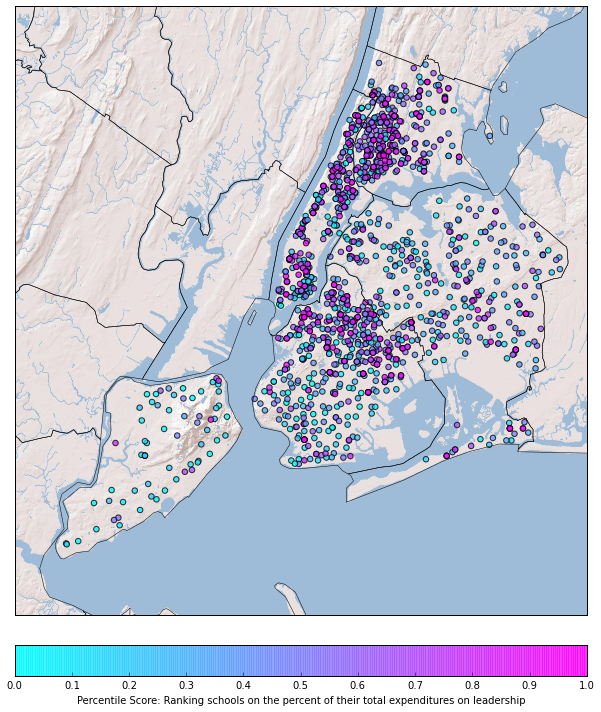

In [99]:
##Recall LCGGEOY is lat, LCGGEOX is long

def NYC_poverty_scatter(ax=None, lllat=40.45, urlat=40.95, lllon=-74.3, urlon=-73.68, year=2010):
    data = all_years_data[year]
    
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111)
    #Create basemap instance
    m = Basemap(ax = ax, 
               lon_0=(urlon + lllon)/2,
               lat_0=(urlat + lllat)/2,
               llcrnrlat=lllat, urcrnrlat=urlat,
               llcrnrlon=lllon, urcrnrlon=urlon,
               resolution='f', epsg=3857)
    #http://server.arcgisonline.com/arcgis/rest/services
    m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)
    m.drawcounties(linewidth=0.5)
    
    ##add points and color bar
    percentiles = [stats.percentileofscore(data['LeadershipSupervisionSupport_All_Funds_percent_of_total'],x,kind='weak')/100.0 for x in data['LeadershipSupervisionSupport_All_Funds_percent_of_total']]
    schools = m.scatter(data['LCGGEOX'].values, data['LCGGEOY'].values, latlon=True, s=30, c=percentiles, alpha=0.8, cmap='cool')
    cbar = m.colorbar(schools,location='bottom',pad="5%")
    cbar.set_label('Percentile Score: Ranking schools on the percent of their total expenditures on leadership')
    return m

NYC_poverty_scatter()

Now that we have a functioning map, let's wrap up in an ipywidget.

In [186]:
##Recall LCGGEOY is lat, LCGGEOX is long


class NYC_school_map(object):
   
    def __init__(self, feature, year):
        self.feature = feature
        self.year = year
        self.basemap, self.ax, self.fig = self.make_NYC_basemap()
        self.feature_map = self.create_initial_NYC_map(self.feature, self.year)
    
    def make_NYC_basemap(self, ax=None, lllat=40.45, urlat=40.95, lllon=-74.3, urlon=-73.68):

        #Create basemap instance
        
        fig = plt.figure(figsize=(12,12))
        ax = plt.subplot(111)
        
        m = Basemap(ax = ax, 
                   lon_0=(urlon + lllon)/2,
                   lat_0=(urlat + lllat)/2,
                   llcrnrlat=lllat, urcrnrlat=urlat,
                   llcrnrlon=lllon, urcrnrlon=urlon,
                   resolution='f', epsg=3857) ###epsg is projection code for ESRI world shaded relief basemap

        #m.arcgisimage uses ESRI REST API (server below) to get basemap 
        #http://server.arcgisonline.com/arcgis/rest/services
        m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500)

        # Add county lines, since boroughs map onto counties
        m.drawcounties(linewidth=0.5)

        return m, ax, fig
    
    def create_initial_NYC_map(self, feature, year):
        fig = self.fig
        ax = self.ax
        m = self.basemap
        
        data = all_years_data[year]
        
        ##add points and color bar
        percentiles = [stats.percentileofscore(data[feature],x,kind='weak')/100.0 for x in data[feature]]
        schools = m.scatter(data['LCGGEOX'].values, data['LCGGEOY'].values, latlon=True, s=30, c=percentiles, alpha=0.8, cmap='cool')
        cbar = m.colorbar(schools,location='bottom',pad="5%")
        label = 'Rank (percentile score) of each school for selected expenditure category'
        cbar.set_label(label)
        
    def interactive_update(self, Expenditure, Year):
        fig = self.fig
        ax = self.ax
        m = self.basemap
        
        data = all_years_data[Year]
        ##add points and color bar
        percentiles = [stats.percentileofscore(data[Expenditure],x,kind='weak')/100.0 for x in data[Expenditure]]
        schools = m.scatter(data['LCGGEOX'].values, data['LCGGEOY'].values, latlon=True, s=30, c=percentiles, alpha=0.8, cmap='cool')
        
        return fig

In [183]:
import re

def cols_in_year(year):
    exp_orig = [re.search(r'_All_Funds_percent_of_total', x) for x in list(all_years_data[year].columns)]
    exp_orig = [x for x in exp_orig if x is not None]
    exp_orig = [x.string for x in exp_orig]
    exp_orig.extend(['Total'])
    dem_orig = ['ell_perc','frl_percent', 'total_enrollment', 'sped_percent', 'asian_per', 'black_per', 'hispanic_per', 'white_per']
    stype_orig = ['Title_1', 'elementary_school', 'middle_school', 'high_school']
    
    stype = clean_features(stype_orig)
    exp = clean_features(exp_orig)
    dem = clean_features(dem_orig)
    return dict(zip(dem, dem_orig)), dict(zip(exp, exp_orig)), dict(zip(stype, stype_orig))

def clean_features(features):
    features = [re.sub('_',' ', x) for x in features]
    features = [x.title() for x in features]
    features = [re.sub('Leadershipsupervisionsupport', 'Leadership, Supervision, and Support', x) for x in features]
    features = [re.sub('Srcs', 'Services', x) for x in features]
    features = [re.sub('Per[c]?$', 'Percent', x) for x in features]
    features = [re.sub(' All Funds', '- All Funds', x) for x in features]
    features = [re.sub(' Percent Of Total', ' (Percent of Total)', x) for x in features]
    features = [re.sub('Ell', 'English Language Learners', x) for x in features]
    features = [re.sub('Sped', 'Special Education', x) for x in features]
    features = [re.sub('Frl', 'Free or Reduced Lunch', x) for x in features]
    features = [re.sub('/s*', '/s', x) for x in features]
    return features

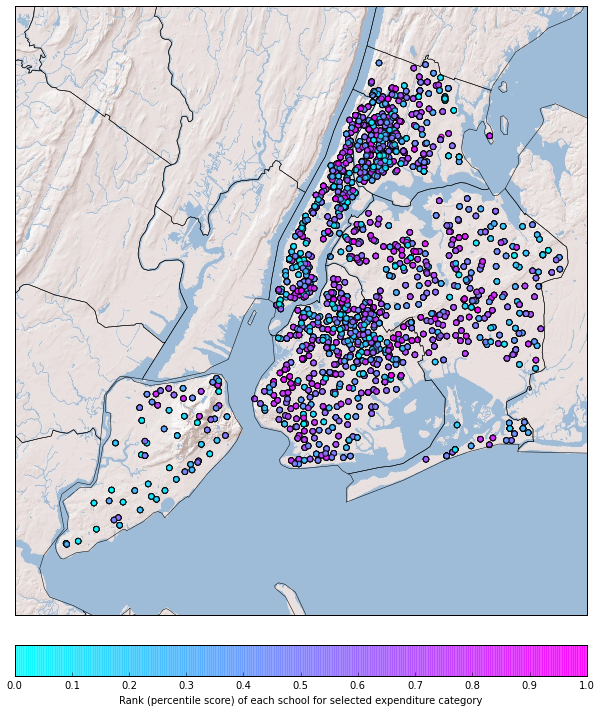

In [187]:
from ipywidgets import widgets, interactive
from IPython.display import display, clear_output

features = cols_in_year(2012)
w = interactive(NYC_school_map('Total',2012).interactive_update, Expenditure = features[1], Year={'2010':2010, '2011':2011, '2012':2012})
w.border_color = 'red'
w.border_style = 'dotted'
w.border_width = 3
display(w)

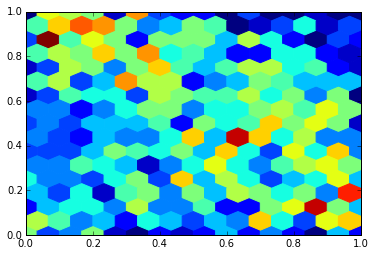

In [181]:
data = all_years_data[2012]
instruction = 'Classroom_Instruction_All_Funds_percent_of_total'
leadership = 'LeadershipSupervisionSupport_All_Funds_percent_of_total'
percentiles_instruction = [stats.percentileofscore(data[instruction],x,kind='weak')/100.0 for x in data[instruction]]
percentiles_leadership = [stats.percentileofscore(data[leadership],x,kind='weak')/100.0 for x in data[leadership]]

plt.hexbin(percentiles_instruction,percentiles_leadership, gridsize=15)

In [176]:
from scipy import stats

stats.linregress(data[leadership], data[instruction])

LinregressResult(slope=-0.26063129738720137, intercept=0.51110586447168749, rvalue=-0.18046155075372969, pvalue=1.6087628934219459e-12, stderr=0.0365806821552064)